**Посмотрим и проанализируем данные:**

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] =  pd.to_datetime(test_data['Date'])

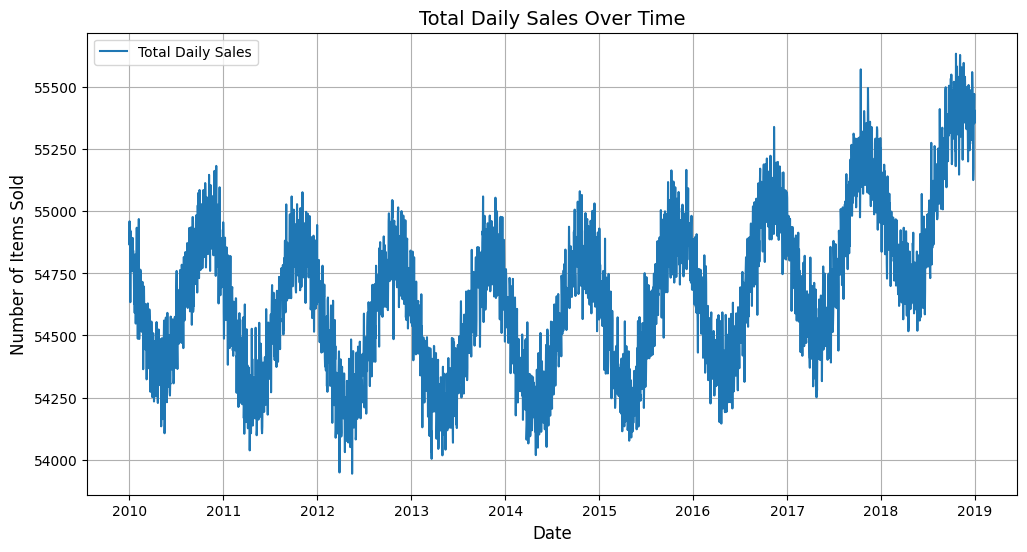

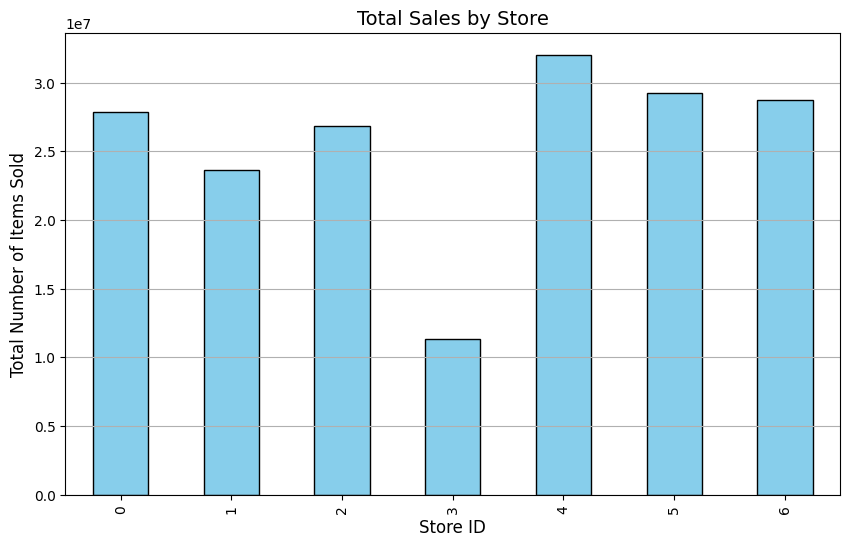

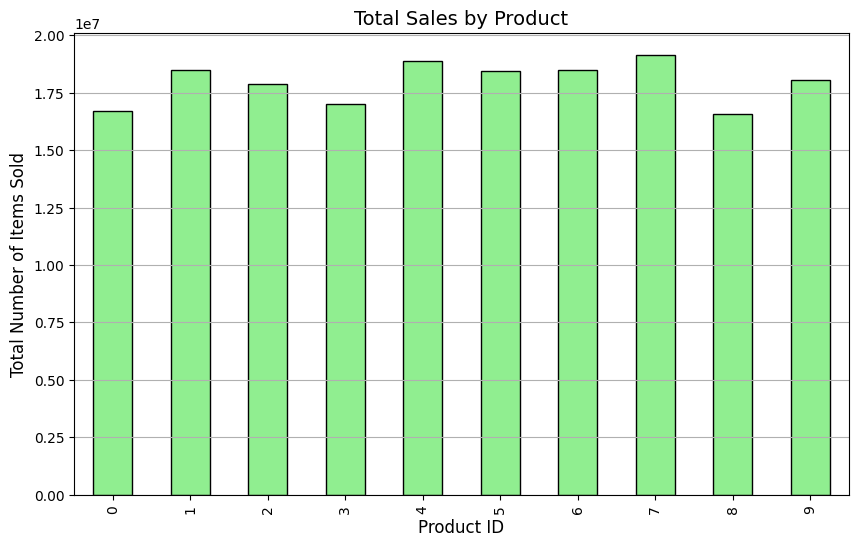

In [2]:
def analyze_total_sales(data):
    daily_sales = data.groupby('Date')['number_sold'].sum()
    plt.figure(figsize=(12, 6))
    plt.plot(daily_sales, label='Total Daily Sales')
    plt.title('Total Daily Sales Over Time', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Items Sold', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

def analyze_sales_by_store(data):
    store_sales = data.groupby('store')['number_sold'].sum()
    plt.figure(figsize=(10, 6))
    store_sales.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Total Sales by Store', fontsize=14)
    plt.xlabel('Store ID', fontsize=12)
    plt.ylabel('Total Number of Items Sold', fontsize=12)
    plt.grid(axis='y')
    plt.show()

def analyze_sales_by_product(data):
    product_sales = data.groupby('product')['number_sold'].sum()
    plt.figure(figsize=(10, 6))
    product_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
    plt.title('Total Sales by Product', fontsize=14)
    plt.xlabel('Product ID', fontsize=12)
    plt.ylabel('Total Number of Items Sold', fontsize=12)
    plt.grid(axis='y')
    plt.show()

analyze_total_sales(train_data)
analyze_sales_by_store(train_data)
analyze_sales_by_product(train_data)

Total Daily Sales Over Time:
- Видны четкие сезонные колебания, пики и падения повторяются ежегодно, что говорит о наличии сезонности в данных.

Total Sales by Store:
- Видно, что некоторые магазины продают больше, чем другие. Магазин с ID 4 имеет максимальные продажи, а магазин с ID 3 — минимальные.

Total Sales by Product:
- Видно, что продажи продуктов распределены довольно равномерно, но есть небольшие отклонения. Продукты с ID 7 и 8 имеют наибольшие продажи.


### Выводы:

**1) Сезонность:**

Наличие сезонных колебаний (ежегодные пики и падения) указывает на то, что модель для прогнозирования должна учитывать сезонность. Это делает SARIMA подходящим выбором, так как она поддерживает работу с сезонными данными.

**2) Магазины:**

Магазины отличаются по объему продаж. Магазин с ID 4 имеет наибольшие продажи, а магазин с ID 3 — наименьшие.
Это различие может быть важно, если мы хотим строить отдельные прогнозы по магазинам. Например, если клиент хочет узнать, сколько конкретный магазин продаст в будущем.

**3) Продукты:**

Продажи продуктов относительно равномерны, но продукты с ID 7 и 8 продаются лучше.
Это различие также может быть важно, если требуется прогнозировать продажи по отдельным продуктам.

**В условии задания написанно: "Колонки с id магазина или id товара могут оказаться бесполезными, их разрешается удалить и работать только с колонкой продаж.". Мы так и поступим, и тогда наша задача сводится к общему прогнозу продаж, и нам хватит агрегированых данных.**


In [3]:
train_data = train_data.drop(columns=['store', 'product'])
test_data = test_data.drop(columns=['store', 'product'])

aggregated_train = train_data.groupby('Date')['number_sold'].sum().reset_index()
aggregated_test = test_data.groupby('Date')['number_sold'].sum().reset_index()

print("Aggregated Train Data:")
print(aggregated_train.head())

print("\nAggregated Test Data:")
print(aggregated_test.head())

Aggregated Train Data:
        Date  number_sold
0 2010-01-01        54870
1 2010-01-02        54960
2 2010-01-03        54863
3 2010-01-04        54926
4 2010-01-05        54634

Aggregated Test Data:
        Date  number_sold
0 2019-01-01        55221
1 2019-01-02        55287
2 2019-01-03        55302
3 2019-01-04        55407
4 2019-01-05        55289


Судя по сезоности ряд у нас не стационарен, но мы все равно декомпозируем его и проведем тест на стационарность.

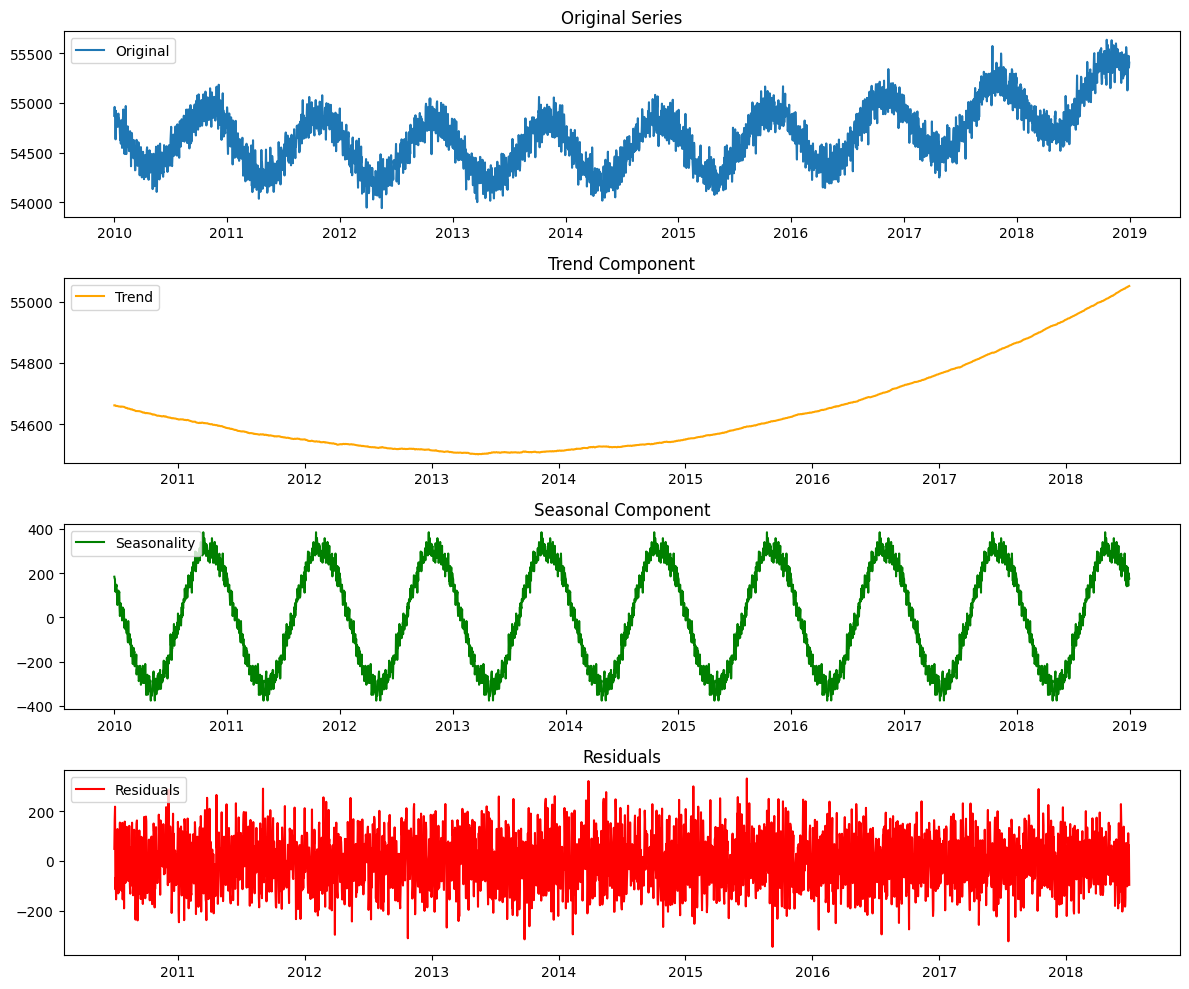

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(aggregated_train['number_sold'], model='addaptive', period=365)


plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(aggregated_train['Date'], aggregated_train['number_sold'], label='Original')
plt.title('Original Series')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(aggregated_train['Date'], result.trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(aggregated_train['Date'], result.seasonal, label='Seasonality', color='green')
plt.title('Seasonal Component')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(aggregated_train['Date'], result.resid, label='Residuals', color='red')
plt.title('Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Original Series:
- Видны как долгосрочный тренд (постепенный рост уровня продаж), так и повторяющиеся пики и спады (сезонность).

Trend Component:
- Тренд сначала показывает небольшой спад (в 2011–2013 годах), а затем постепенный рост (с 2014 года до конца данных).

Seasonal Component:
- Повторяющиеся шаблоны, которые происходят через регулярные интервалы (365 дней).

Residuals:
- Остатки выглядят случайными, что говорит о том, что тренд и сезонность успешно описали основные закономерности.



### Выводы:
- Ряд нестационарный, так как среднее значение со временем меняется.
- Сезонность повторяется с определенным периодом (365 дней).
- Продажи увеличиваются со временем, что может быть связано с расширением бизнеса или ростом спроса.
- Для прогнозирования нужно либо учесть этот тренд, либо удалить его, чтобы сделать ряд стационарным.
- В данном случае остатки выглядят случайными, что говорит о том, что тренд и сезонность успешно описали основные закономерности.


In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(aggregated_train['number_sold'])

print("ADF Statistic:", result[0])  
print("p-value:", result[1])        
print("Critical Values:", result[4])  

ADF Statistic: -2.5323697134561005
p-value: 0.10779573173606516
Critical Values: {'1%': -3.4323593525669414, '5%': -2.8624278120183573, '10%': -2.567242601304915}


***Тест Дики-Фуллера, подтверждает, что ряд не стационарен.*** 

In [6]:
aggregated_train['diff_1'] = aggregated_train['number_sold'].diff()
result_diff = adfuller(aggregated_train['diff_1'].dropna())


Сделаем дифференцирование

In [ ]:
print("ADF Statistic:", result_diff[0])  
print("p-value:", result_diff[1])        
print("Critical Values:", result_diff[4])  

if result_diff[1] < 0.05:
    print("Ряд стационарен после первого дифференцирования.")
else:
    print("Ряд все еще не стационарен.")


ADF Statistic: -7.113038701556091
p-value: 3.8942498293823326e-10
Critical Values: {'1%': -3.432359970177518, '5%': -2.862428084811229, '10%': -2.5672427465340872}
Ряд стационарен после первого дифференцирования.


Тренд успешно удален из данных.
Ряд теперь имеет постоянное среднее и дисперсию, что делает его подходящим для моделирования с использованием ARIMA/SARIMA.


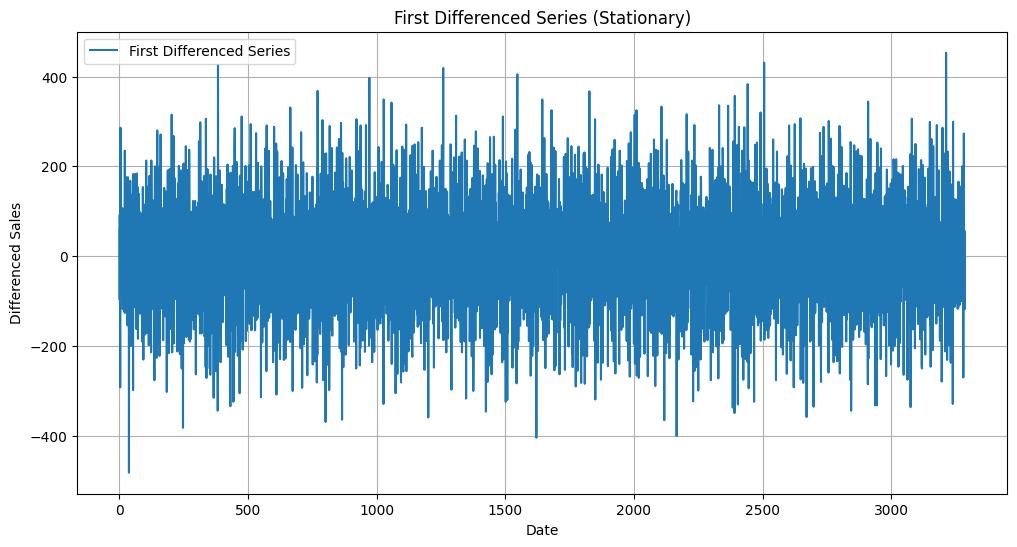

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(aggregated_train['diff_1'], label='First Differenced Series')
plt.title('First Differenced Series (Stationary)')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.legend()
plt.grid()
plt.show()


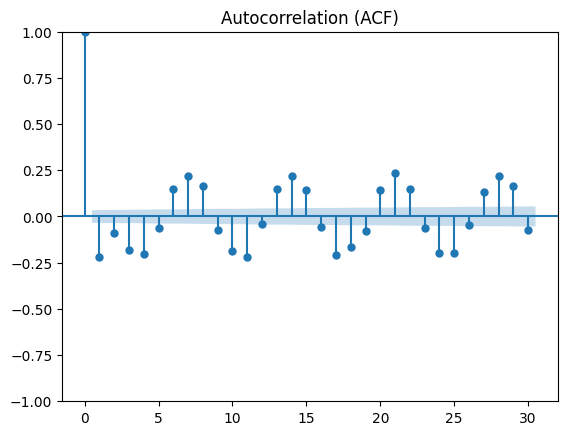

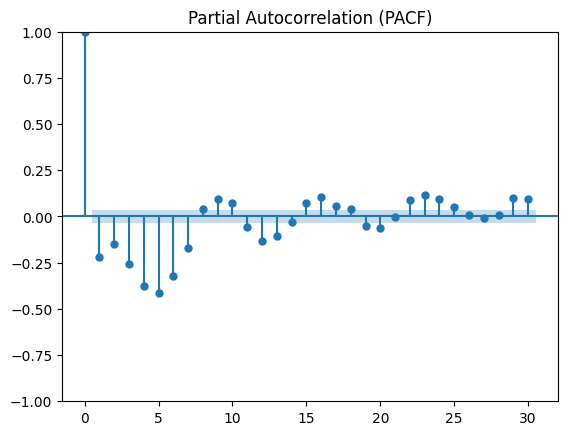

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(aggregated_train['diff_1'].dropna(), lags=30)
plt.title('Autocorrelation (ACF)')
plt.show()

plot_pacf(aggregated_train['diff_1'].dropna(), lags=30)
plt.title('Partial Autocorrelation (PACF)')
plt.show()


**Autocorrelation Function:**
- Значимые пики на первых нескольких лагах, затем автокорреляция быстро затухает.
- Это говорит о том, что значения ряда зависят от недавних значений (например, лагов 1, 2, 3), а затем связь ослабевает.

**Partial Autocorrelation Function:**
- Значимые пики на первых двух лагах (лаг 1 и лаг 2) — это означает, что значения ряда сильно зависят от 1-2 предыдущих значений.

**Исходя из графиков, аозьмем следуюшие параметры:**

P = 2 (PACF показывает значимые пики на лагах 1 и 2)

Q = 2 (ACF видны значимые пики на лагах 1 и 2)

### SARIMA

Для оптимизации расчетов перейдем на еженедельные данные.

In [10]:
weekly_train = aggregated_train.resample('W-MON', on='Date').sum().reset_index()
weekly_test = aggregated_test.resample('W-MON', on='Date').sum().reset_index()

print(weekly_train.head())
print(weekly_test.head())


        Date  number_sold  diff_1
0 2010-01-04       219619    56.0
1 2010-01-11       383698  -134.0
2 2010-01-18       383651    24.0
3 2010-01-25       382814  -163.0
4 2010-02-01       383413   139.0
        Date  number_sold
0 2019-01-07       387008
1 2019-01-14       387051
2 2019-01-21       386754
3 2019-01-28       386778
4 2019-02-04       386733


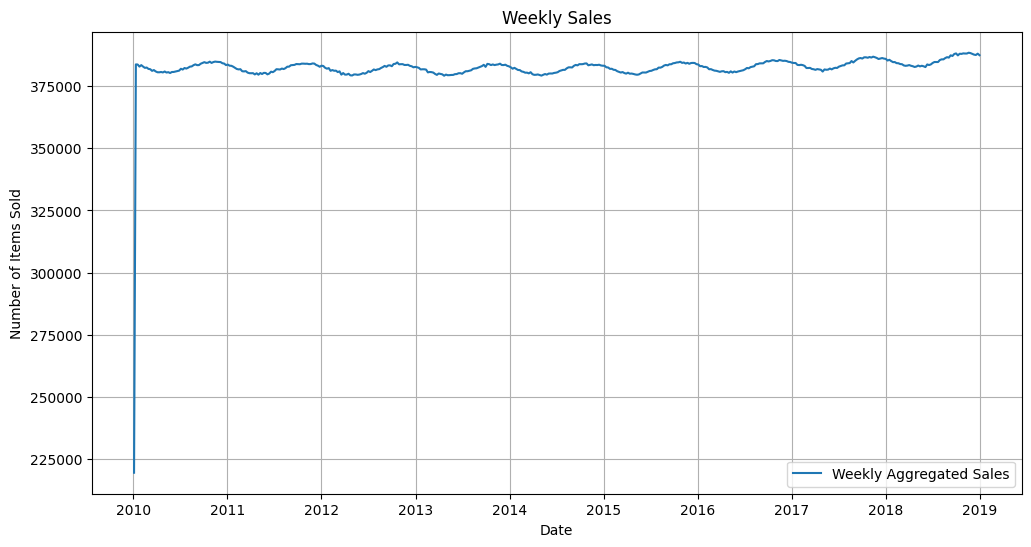

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_train['Date'], weekly_train['number_sold'], label='Weekly Aggregated Sales')
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Number of Items Sold')
plt.legend()
plt.grid()
plt.show()


**Проблемы:**
Аномальные всплески в начале ряда, возможно, аномалии в начале ряда вызваны всплесками данных после ресемплинга.

Удалим начальные данные:

In [12]:
weekly_train_trimmed = weekly_train.iloc[1:].reset_index(drop=True)

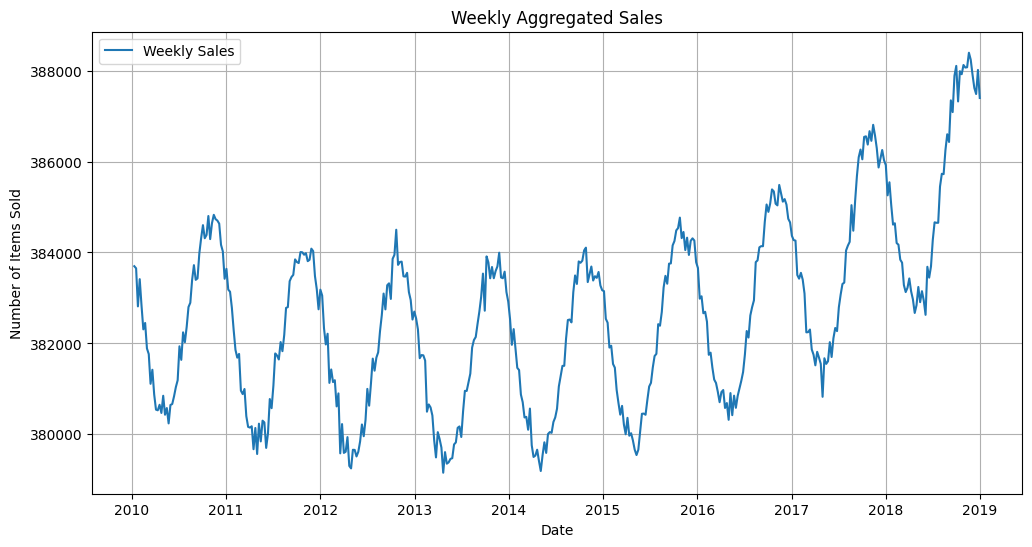

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_train_trimmed['Date'], weekly_train_trimmed['number_sold'], label='Weekly Sales')
plt.title('Weekly Aggregated Sales')
plt.xlabel('Date')
plt.ylabel('Number of Items Sold')
plt.legend()
plt.grid()
plt.show()


Так же прологарифмируем ряд, сгладить данные.

In [14]:
import numpy as np

weekly_train_trimmed['log_number_sold'] = np.log(weekly_train_trimmed['number_sold'])

Обучем модель и посмотрим на результаты:

In [15]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

weekly_train_trimmed['log_number_sold'] = np.log(weekly_train_trimmed['number_sold'])

model_log = SARIMAX(
    weekly_train_trimmed['log_number_sold'],
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_model_log = model_log.fit(disp=False)
print(sarima_model_log.summary())


                                      SARIMAX Results                                       
Dep. Variable:                      log_number_sold   No. Observations:                  469
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood                2087.283
Date:                              Wed, 20 Nov 2024   AIC                          -4160.566
Time:                                      20:59:20   BIC                          -4133.344
Sample:                                           0   HQIC                         -4149.743
                                              - 469                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4624      0.437     -1.057      0.290      -1.320       0.395
ar.L2         -0.13

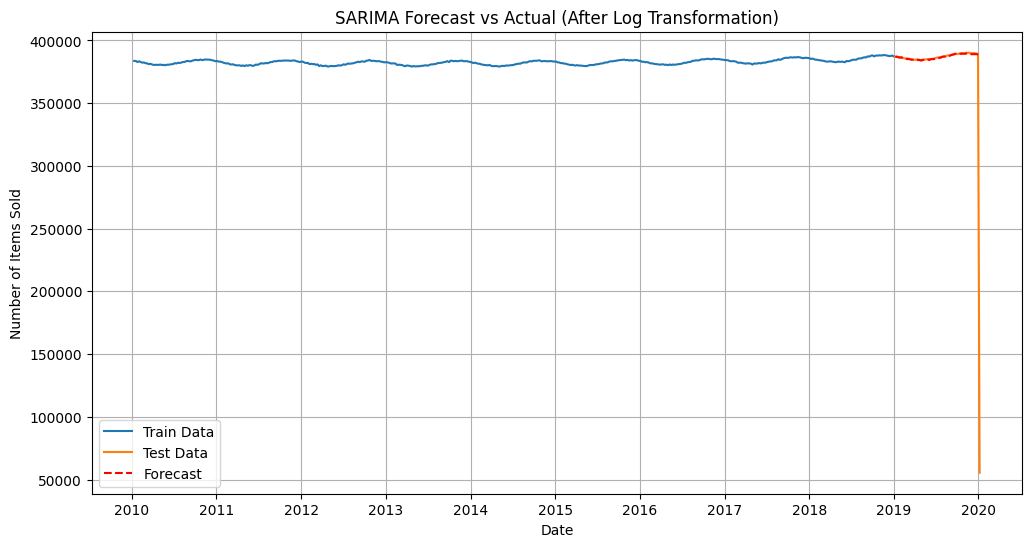

MAPE: 0.1141
RMSE: 45719.3506
R^2: -0.0244


/home/alex/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
forecast_steps = len(weekly_test)  
forecast_log = sarima_model_log.forecast(steps=forecast_steps)

forecast = np.exp(forecast_log)  

plt.figure(figsize=(12, 6))
plt.plot(weekly_train_trimmed['Date'], weekly_train_trimmed['number_sold'], label='Train Data')
plt.plot(weekly_test['Date'], weekly_test['number_sold'], label='Test Data')
plt.plot(weekly_test['Date'], forecast, label='Forecast', linestyle='--', color='red')
plt.title('SARIMA Forecast vs Actual (After Log Transformation)')
plt.xlabel('Date')
plt.ylabel('Number of Items Sold')
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

mape = mean_absolute_percentage_error(weekly_test['number_sold'], forecast)
rmse = mean_squared_error(weekly_test['number_sold'], forecast, squared=False)
r2 = r2_score(weekly_test['number_sold'], forecast)

print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

## Результаты:

**MAPE: 0.1141**

- Процентная ошибка указывает, что модель в среднем ошибается на 11.41% при прогнозировании еженедельных данных.

**RMSE: 45719.3506**

- Среднеквадратичная ошибка достаточно велика в абсолютных числах, вероятно это связано с крупными масштабами продаж.

**R^2: -0.0244**

- Отрицательное значение показывает, что модель предсказывает хуже, чем простое усреднение данных. Это значит, что модель не смогла захватить сложные зависимости в данных.

## Выводы:

**Сезонность:**

- Модель хорошо захватила сезонные колебания (52 недели), но остатки всё ещё содержат информацию, которую модель не смогла объяснить.

**Шум:**

- Данные содержат значительное количество шума, что затрудняет точное прогнозирование.

**Тренд:**

- Долгосрочный тренд не был полностью описан моделью, особенно в тестовом наборе.